# Integrating Product Design and Supply Chain Design

## Import Packages

In [780]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv
import random
import math
import sys

In [781]:
def handleGurobiStatus(m : gp.Model):
    status = m.status
    if status == GRB.Status.INFEASIBLE:
        print("The model is infeasible. Computing IIS.")
        m.computeIIS()
        m.write('iismodel.ilp')
        sys.exit(0)
    elif status == GRB.Status.UNBOUNDED:
        print("The model is unbounded.")
        sys.exit(0)
    elif status == GRB.Status.OPTIMAL:
        print("The model is optimal.")
    elif status == GRB.Status.INF_OR_UNBD:  
        print("The model status is infeasible or unbounded. Set DualReductions parameter to 0 and reoptimize.")
        sys.exit(0)
    else:
        print("The model status is neither infeasible nor unbounded.")
        sys.exit(0)

## Parameters

In [782]:
timeUB = 3
numTiers = 2
numOptions = 2

safetyFactor = 1
sigma = 1
holdingCostRate = 0.1

In [783]:
np.random.seed(0)

In [784]:
def get_descendent_parts(G: nx.DiGraph, node):
    myList = [i for i in nx.ancestors(G, node) if G.nodes[i]['tier'] == numTiers]
    if G.nodes[node]['tier'] == numTiers:
        myList.append(node)
    return myList

## BOM: Components

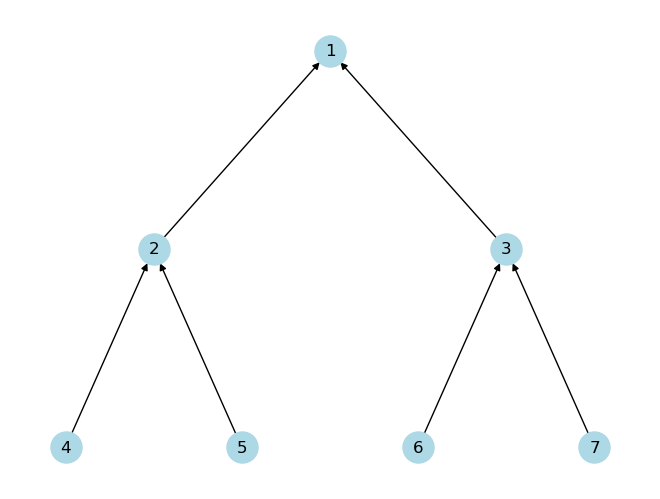

In [785]:
def add_edges(G, node, depth, pos, x=0, y=0, dx=1):
    pos[node] = (x, y)
    G.nodes[node]['depth'] = depth
    #print(node, G.nodes[node])
    if depth > 0:
        node_left = node*2
        node_right = node*2 + 1
        G.add_edge(node_left, node)
        G.add_edge(node_right, node)
        add_edges(G, node_left, depth-1, pos, x-dx, y-1, dx/2)
        add_edges(G, node_right, depth-1, pos, x+dx, y-1, dx/2)

def buildBOMGraph():
    G = nx.DiGraph()
    root_node = 1
    pos = {}
    G.add_node(root_node, depth = numTiers, tier = 0)
    #print(G.nodes(data=True))
    add_edges(G, root_node, numTiers, pos)
    for i in G.nodes():
        time = np.random.randint(1, timeUB)
        if i == root_node:
            maxTime = 0
        else:
            maxTime = 100
        G.nodes[i]['process_time'] = time
        G.nodes[i]['max_service_time_out'] = maxTime
        G.nodes[i]['stage_cost'] = np.random.randint(1, 6)
        G.nodes[i]['tier'] = numTiers - G.nodes[i]['depth']
        G.nodes[i]['pos'] = pos[i]
    for i in G.nodes():
        G.nodes[i]['desc_parts'] = get_descendent_parts(G, i)
    return G, pos

bomGraph, bomGraphPos = buildBOMGraph()
nx.draw(bomGraph, bomGraphPos, with_labels=True, node_color='lightblue', node_size=500)
plt.show()

maxServiceTimeOut = nx.get_node_attributes(bomGraph, 'max_service_time_out')
processTimesDict = nx.get_node_attributes(bomGraph, 'process_time')
stageCostDict = nx.get_node_attributes(bomGraph, 'stage_cost')
maxServiceTimeOut = nx.get_node_attributes(bomGraph, 'max_service_time_out')

## BOM Graph: Part Options

In [786]:
def getLeafNodes(G):
    return [i for i in G.nodes() if G.nodes[i]['tier'] == numTiers]

numLeafNodes = len(getLeafNodes(bomGraph))

In [787]:
# def createBOM_with_options(bomGraph : nx.DiGraph, bomGraphPos : dict, sameTimes = True, sameCosts = True):
#     G = nx.DiGraph()
#     G.add_nodes_from(bomGraph.nodes(data=True))
#     G.add_edges_from(bomGraph.edges(data=True))
#     newPos = bomGraphPos.copy()
#     for i in getLeafNodes(bomGraph):
#         if sameTimes:
#             time = bomGraph.nodes[i]['process_time']
#             G.nodes[i]['process_times'] = [time, time]
#         else:
#             G.nodes[i]['process_times'] = np.random.randint(1, timeUB, numOptions)
#         if sameCosts:
#             cost = bomGraph.nodes[i]['stage_cost']
#             G.nodes[i]['stage_costs'] = [cost, cost]
#         else:
#             G.nodes[i]['stage_costs'] = np.random.randint(1, 6, numOptions)
#     return G, newPos

In [788]:
def getMaxReplenishmentTime(G : nx.DiGraph, n : int):
    if G.nodes[n]['tier'] == numTiers:
        return processTimesDict[n]
    else:
        return processTimesDict[n] + max([getMaxReplenishmentTime(G, i) for i in G.predecessors(n)])
    
def getCumCost(G : nx.DiGraph, n : int):
    if G.nodes[n]['tier'] == numTiers:
        return stageCostDict[n]
    else:
        return stageCostDict[n] + sum([getCumCost(G, i) for i in G.predecessors(n)])

maxReplenishmentTime = {n : getMaxReplenishmentTime(bomGraph, n) for n in bomGraph.nodes()}
cumCost = {n : getCumCost(bomGraph, n) for n in bomGraph.nodes()}

df = pd.DataFrame({
    'Node': maxReplenishmentTime.keys(),
    'Process time': processTimesDict.values(),
    'Stage cost': stageCostDict.values(),
    'Cumulative cost': cumCost.values(),
    'Max time': maxServiceTimeOut.values(),
    'maxReplenishmentTime': maxReplenishmentTime.values()
})
df.to_csv('instance.csv')
df

,Node,Process time,Stage cost,Cumulative cost,Max time,maxReplenishmentTime
0,1,1,1,18,0,5
1,2,2,4,8,100,4
2,3,2,2,9,100,3
3,4,2,3,3,100,2
4,5,1,1,1,100,1
5,6,1,5,5,100,1
6,7,1,2,2,100,1


In [789]:
def get_sIn_range_for_g_fn(node : int):
    maxVal = maxReplenishmentTime[node] - processTimesDict[node]
    return range(maxVal + 1)

def get_sOut_range_for_g_fn_forIn(G : nx.DiGraph, node : int, sIn : int):
    maxVal = sIn + processTimesDict[node]
    if G.nodes[node]['tier'] < numTiers:
        maxVal = min(maxVal, maxServiceTimeOut[node])
    return range(maxVal+1)

def get_sOut_range_for_g_fn_all(G : nx.DiGraph,node : int):
    vals = set()
    for sIn in get_sIn_range_for_g_fn(node):
        vals = vals.union(set(get_sOut_range_for_g_fn_forIn(G, node, sIn)))
    return vals

def get_possible_sin_for_sout_at_pred(node : int, sOut_at_pred : int, maxSOut_at_pred : int):
    if sOut_at_pred == maxSOut_at_pred:
        return [sIn for sIn in get_sIn_range_for_g_fn(node) if sIn >= sOut_at_pred]
    else:
        return [sOut_at_pred]

def getHoldingCost(node : int, sIn : int, sOut : int):
    if sIn + processTimesDict[node] - sOut < 0:
        raise ValueError("node", node, "sIn + processTimesDict[node] - sOut < 0")
    return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimesDict[node] - sOut)

# def getHoldingCostOnEdgeForPart(node : int, part : int, sIn : int, sOut : int):
#     return safetyFactor*sigma*holdingCostRate*stageCostDict[part]*np.sqrt(sIn + processTimesDict[node] - sOut)

# def getHoldingCostOnEdgeForEdgeOnly(G : nx.DiGraph, e : tuple):
#     id = G.nodes[e[0]]['id']
#     attrDict = e[2]
#     intime = attrDict['intime']
#     outtime = attrDict['outtime']
#     return safetyFactor*sigma*holdingCostRate*stageCostDict[id]*np.sqrt(intime + processTimesDict[id] - outtime)

def getNodeString(node : int, s : int, isOut : bool):
    if isOut:
        return "{}^{}".format(node, s)
    else:
        return "{}_{}".format(node, s)

## Extended Graph

In [790]:
def createExtendedGraph(bomGraph : nx.DiGraph, pos : dict, yOffSet = 0.25):
    G = nx.DiGraph()
    newPos = {}
    xOffPerNode = 0.25
    for i in bomGraph.nodes():
        numSIn = len(get_sIn_range_for_g_fn(i))
        xPos = -((numSIn - 1)*xOffPerNode)/2
        for sIn in get_sIn_range_for_g_fn(i):
            inNodeStr = getNodeString(i, sIn, False)
            G.add_node(inNodeStr, process_time=0, 
               max_service_time_out=0,
               stage_cost=0, inout = 'in',
               id = i, 
               tier = bomGraph.nodes[i]['tier'])
            newPos[inNodeStr] = (pos[i][0] + xPos, pos[i][1] - yOffSet)
            xPos += xOffPerNode
        numSOut = len(get_sOut_range_for_g_fn_all(bomGraph, i))
        xPos = -((numSOut - 1)*xOffPerNode)/2
        for sOut in get_sOut_range_for_g_fn_all(bomGraph, i):
            outNodeStr = getNodeString(i, sOut, True)
            G.add_node(outNodeStr, process_time=0, 
               max_service_time_out=0,
               stage_cost=0, inout = 'out',
               id = i,
               tier = bomGraph.nodes[i]['tier'])
            newPos[outNodeStr] = (pos[i][0] + xPos, pos[i][1] + yOffSet)
            xPos += xOffPerNode
        for sIn in get_sIn_range_for_g_fn(i):
            for sOut in get_sOut_range_for_g_fn_forIn(bomGraph, i, sIn):
                nodeTupleIn = getNodeString(i, sIn, False)
                nodeTupleOut = getNodeString(i, sOut, True)
                G.add_edge(nodeTupleIn, nodeTupleOut, intime = sIn, outtime = sOut,
                            cost = getHoldingCost(i, sIn, sOut), type = 'net-time')
    for (i,j) in bomGraph.edges():
        maxSOut_at_pred = max(get_sOut_range_for_g_fn_all(bomGraph, i))
        for sOut in get_sOut_range_for_g_fn_all(bomGraph, i):
            for sIn in get_possible_sin_for_sout_at_pred(j, sOut, maxSOut_at_pred):
                nodeTupleOut = getNodeString(i, sOut, True)
                nodeTupleIn = getNodeString(j, sIn, False)
                G.add_edge(nodeTupleOut, nodeTupleIn, intime = sIn, 
                           outtime = sOut, 
                                cost = 0, type = 'node-to-node')
    return G, newPos

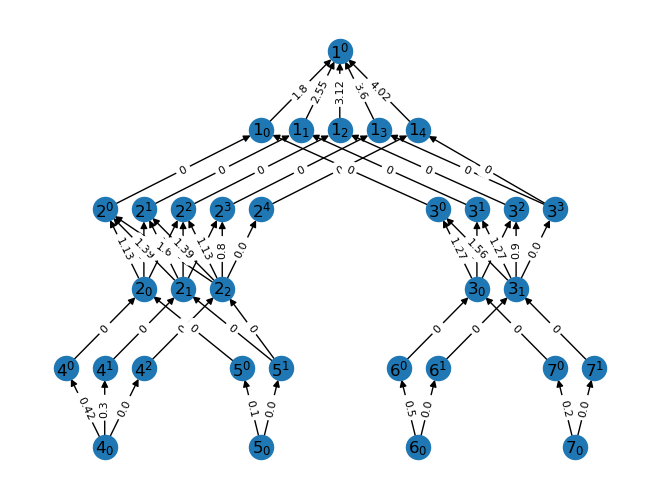

In [791]:
extGraph, extGraphPos = createExtendedGraph(bomGraph, bomGraphPos)
node_labels = {node: r'$' +node + '$' for node in extGraph.nodes()}
nx.draw(extGraph, extGraphPos, labels = node_labels, with_labels=True)
edge_labels = {(u, v): round(data['cost'],2) 
              for u, v, data in extGraph.edges(data=True)}
nx.draw_networkx_edge_labels(extGraph, extGraphPos, edge_labels=edge_labels, font_size=8)
plt.show()

## Show Shortest Paths

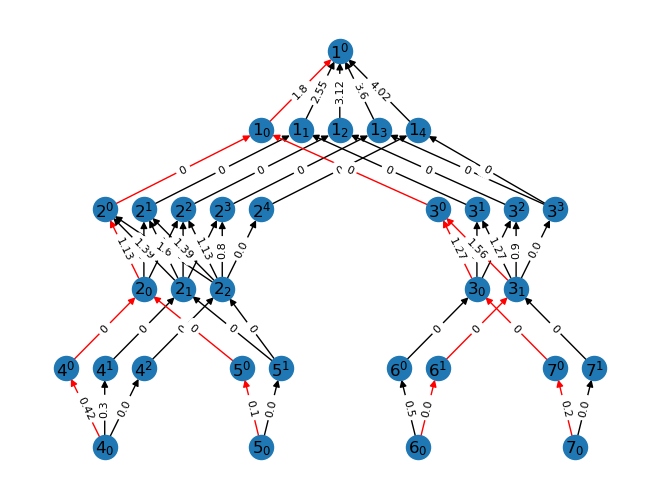

In [792]:
edgesUsed = []
for n in ['4_0', '5_0', '6_0', '7_0']:
    shortest_path = nx.shortest_path(extGraph, n, '1^0', weight='cost')
    edges_in_path = list(zip(shortest_path[:-1], shortest_path[1:]))
    edgesUsed.extend(edges_in_path)
edgesUsedSet = set(edgesUsed)

edge_colors = ['red' if edge in edgesUsedSet else 'black' for edge in extGraph.edges()]

nx.draw(extGraph, extGraphPos, labels = node_labels, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(extGraph, extGraphPos, edge_labels=edge_labels, font_size=8)
plt.show()

Note that two different 'net-time' edges are used for node 2, which is not allowed.

In [793]:
def getNetFlowExpr(G, x, node):
    return qsum(x[e] for e in G.out_edges(node)) - qsum(x[e] for e in G.in_edges(node))

tier = nx.get_node_attributes(extGraph, 'tier')
inout = nx.get_node_attributes(extGraph, 'inout')

def getTier(G : nx.DiGraph, n : int):
    return G.nodes[n]['tier']

def getInOut(G : nx.DiGraph, n : int):
    return G.nodes[n]['inout']

def getAllNetTimeEdges(G : nx.DiGraph):
    for e in G.edges:
        if G.edges[e]['type'] == 'net-time':
            yield e

def getAllNetTimeEdgeWithData(G : nx.DiGraph):
    for e in G.edges(data = True):
        if G.edges[e[0], e[1]]['type'] == 'net-time':
            yield e

def getAllNodeToNodeEdges(G : nx.DiGraph):
    for e in G.edges:
        if G.edges[e]['type'] == 'node-to-node':
            yield e

def getNetFlowExprRHS(n : int):
    if tier[n] == numTiers and inout[n] == 'in':
        return 1
    elif tier[n] == 0 and inout[n] == 'out':
        return -numLeafNodes
    else:
        return 0
    
def getNodeIDForNetTimeEdge(extGraph : nx.DiGraph, e : tuple):
    id = extGraph.nodes[e[0]]['id']
    return id

def getNumDescLeafNodesForNetTimeEdge(bomGraph : nx.DiGraph, 
                                      extGraph : nx.DiGraph, e : tuple):
    id = getNodeIDForNetTimeEdge(extGraph, e)
    return len(get_descendent_parts(bomGraph, id))

def getDescLeafNodesForNode(bomGraph : nx.DiGraph, extGraph : nx.DiGraph, 
                            node : str):
    id = extGraph.nodes[node]['id']
    return get_descendent_parts(bomGraph, id)

In [794]:
def getOptimizedShortestPathModel(G : nx.DiGraph, vtypeY = GRB.BINARY, log = False):
    m = gp.Model("shortest_path")
    m.Params.LogToConsole = log
    
    x = m.addVars(G.edges(), name="x")
    y = m.addVars(getAllNetTimeEdges(G), name="y", vtype=vtypeY)
    m._x = x
    m._y = y

    m.setObjective(qsum(x[e]*G.edges[e]['cost'] for e in getAllNodeToNodeEdges(G)) + 
                qsum(y[e]*G.edges[e]['cost'] for e in y), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= getNumDescLeafNodesForNetTimeEdge(bomGraph, extGraph, e)*y[e] 
                                        for e in y), "UB")
    m.addConstrs((getNetFlowExpr(G, x, n) == getNetFlowExprRHS(n) 
                for n in G.nodes()), "netflow")

    m.optimize()
    handleGurobiStatus(m)
    m.write('shortest_path.lp')
    return m

m = getOptimizedShortestPathModel(extGraph, vtypeY = GRB.CONTINUOUS)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))
edgesUsedRelaxed = list({(e[0], e[1]) for e in m._x if m._x[e].x > 0.0})
m = getOptimizedShortestPathModel(extGraph, log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))
xVals = [m._x[e].x for e in m._x if m._x[e].x > 0.0]
edgesUsedOptimal = list({(e[0], e[1]) for e in m._x if m._x[e].x > 0.0})
costs = [extGraph.edges[e]['cost'] for e in edgesUsedOptimal]

df = pd.DataFrame({
    'Edge used': edgesUsedOptimal,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
df

The model is optimal.
Relaxed Cost: $ 3.69
The model is optimal.
Optimal Cost: $ 3.90


,Edge used,Holding cost
0,"(5_0, 5^1)",$0.00
1,"(4_0, 4^1)",$0.30
2,"(2^3, 1_3)",$0.00
3,"(3_1, 3^3)",$0.00
4,"(2_1, 2^3)",$0.00
5,"(4^1, 2_1)",$0.00
6,"(5^1, 2_1)",$0.00
7,"(3^3, 1_3)",$0.00
8,"(7_0, 7^1)",$0.00
9,"(6_0, 6^1)",$0.00


## Edges Used: Relaxed  

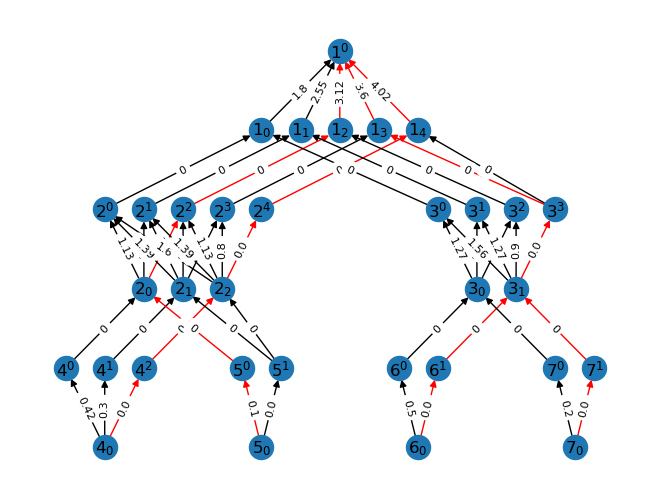

In [795]:
edge_colors = ['red' if edge in edgesUsedRelaxed else 'black' for edge in extGraph.edges()]

nx.draw(extGraph, extGraphPos, labels = node_labels, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(extGraph, extGraphPos, edge_labels=edge_labels, font_size=8)
plt.show()

## Edges Used: Optimal

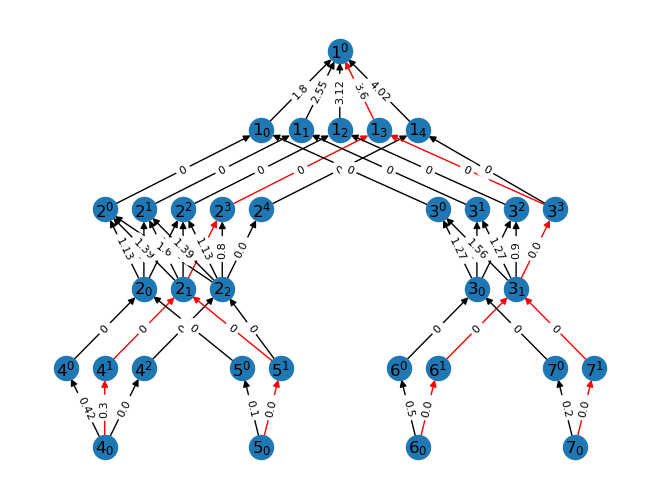

In [796]:
edge_colors = ['red' if edge in edgesUsedOptimal else 'black' for edge in extGraph.edges()]

nx.draw(extGraph, extGraphPos, labels = node_labels, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(extGraph, extGraphPos, edge_labels=edge_labels, font_size=8)
plt.show()

## Extended Multicommodity Graph

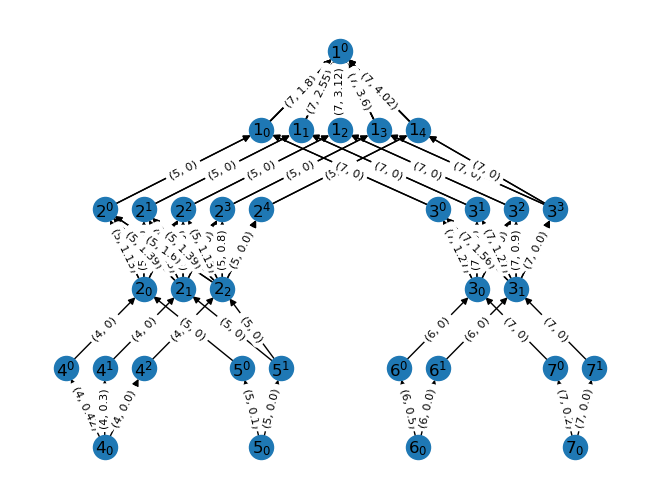

In [797]:
def createExtendedMultiGraph(extGraph : nx.DiGraph):
    G = nx.MultiDiGraph()
    G.add_nodes_from(extGraph.nodes(data=True))
    for e in extGraph.edges(data = True):
        id = extGraph.nodes[e[0]]['id']
        for p in get_descendent_parts(bomGraph, id):
            attrDict = e[2]
            intime = attrDict['intime']
            outtime = attrDict['outtime']
            attrDict['part'] = p
            G.add_edge(e[0], e[1], **attrDict)
    return G

extMultiGraph = createExtendedMultiGraph(extGraph)

node_labels = {node: r'$' +node + '$' for node in extMultiGraph.nodes()}
nx.draw(extMultiGraph, extGraphPos, labels = node_labels, with_labels=True)
edge_labels = {(u, v): (data['part'], round(data['cost'],2)) 
              for u, v, data in extMultiGraph.edges(data=True)}
nx.draw_networkx_edge_labels(extMultiGraph, extGraphPos, edge_labels=edge_labels, font_size=8)
plt.show()

In [798]:
def getCommodityEdges(extMultiGraph : nx.MultiDiGraph):
    return [(e[0], e[1], e[2]['part']) for e in extMultiGraph.edges(data = True)]

def getCommodityInEdgesForNode(G, node):
    return [(e[0], e[1], e[2]['part']) for e in G.in_edges(node, data = True)]

def getCommodityOutEdgesForNode(G, node):
    return [(e[0], e[1], e[2]['part']) for e in G.out_edges(node, data = True)]

In [799]:
def getNetFlowExpr(G, x, node):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNode(G, node))
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdgesForNode(G, node))
    return out_edges_sum - in_edges_sum

def getNetFlowExprWithPart(G, x, node, part):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNode(G, node) 
                        if e[2] == part)
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdgesForNode(G, node) 
                         if e[2] == part)
    return out_edges_sum - in_edges_sum

def getAllNetTimeEdgeCommodities(G : nx.DiGraph):
    for e in G.edges(data = True):
        if e[2]['type'] == 'net-time':
            yield (e[0], e[1], e[2]['part'])

def getAllNodeToNodeEdgeCommodities(G : nx.DiGraph):
    for e in G.edges(data = True):
        if e[2]['type'] == 'node-to-node':
            yield (e[0], e[1], e[2]['part'])

def getNetFlowExprRHS_multicommod(G : nx.DiGraph, n : int):
    tier = getTier(G, n)
    inout = getInOut(G, n)
    if tier == numTiers and inout == 'in':
        return 1
    elif tier == 0 and inout == 'out':
        return -1
    else:
        return 0

edgeCostCommodity = {(e[0], e[1], e[2]['part']) : e[2]['cost'] 
                for e in extMultiGraph.edges(data = True)}
    
edgeCostZ = {(e[0], e[1]) : e[2]['cost']
            for e in getAllNetTimeEdgeWithData(extGraph)}

def getOptimizedShortestPathModelMulticommodity(extGraph : nx.MultiDiGraph,
                                                extMultiGraph : nx.MultiDiGraph, 
                                                vtypeZ = GRB.BINARY, 
                                                log = False):
    m = gp.Model("shortest_paths")
    m.Params.LogToConsole = log
    x = m.addVars(getCommodityEdges(extMultiGraph), name="x")
    z = m.addVars(getAllNetTimeEdges(extGraph), name="z", vtype=vtypeZ)
    m._x = x
    m._z = z

    m.setObjective(qsum(edgeCostCommodity[e]*x[e] for e in getAllNodeToNodeEdgeCommodities(extGraph)) + 
                qsum(z[e]*edgeCostZ[e] for e in z), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= z[e[0],e[1]] 
                  for e in getAllNetTimeEdgeCommodities(extMultiGraph)), 
                 "UB-z")
    m.addConstrs((getNetFlowExprWithPart(extMultiGraph, x, n, p) == getNetFlowExprRHS_multicommod(extMultiGraph, n) 
                for n in extMultiGraph.nodes() 
                for p in getDescLeafNodesForNode(bomGraph, extGraph, n)), "netflow-multi")
    m.optimize()
    m.write("multicommodity.lp")
    handleGurobiStatus(m)
    return m

In [800]:
m = getOptimizedShortestPathModelMulticommodity(extGraph, extMultiGraph, 
                                                vtypeZ = GRB.CONTINUOUS, log = False)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))

edgesUsedRelaxedMulticommod = list({e for e in m._x if m._x[e].x > 0.0})
costs = [edgeCostCommodity[e] for e in edgesUsedRelaxedMulticommod]

df = pd.DataFrame({
    'Edge used': edgesUsedRelaxedMulticommod,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
print(df)

The model is optimal.
Relaxed Cost: $ 3.90
        Edge used Holding cost
0   (5_0, 5^1, 5)        $0.00
1   (2^3, 1_3, 4)        $0.00
2   (7^1, 3_1, 7)        $0.00
3   (2_1, 2^3, 4)        $0.00
4   (1_3, 1^0, 6)        $3.60
5   (3_1, 3^3, 7)        $0.00
6   (5^1, 2_1, 5)        $0.00
7   (6^1, 3_1, 6)        $0.00
8   (4_0, 4^1, 4)        $0.30
9   (6_0, 6^1, 6)        $0.00
10  (1_3, 1^0, 5)        $3.60
11  (7_0, 7^1, 7)        $0.00
12  (3_1, 3^3, 6)        $0.00
13  (3^3, 1_3, 7)        $0.00
14  (2^3, 1_3, 5)        $0.00
15  (4^1, 2_1, 4)        $0.00
16  (2_1, 2^3, 5)        $0.00
17  (1_3, 1^0, 4)        $3.60
18  (1_3, 1^0, 7)        $3.60
19  (3^3, 1_3, 6)        $0.00


In [801]:
edgesUsedZ = list({e for e in m._z if m._z[e].x > 0.0})
costsZ = [edgeCostZ[e] for e in edgesUsedZ]
df = pd.DataFrame({
    'Edge used': edgesUsedZ,
    'Holding cost': costsZ
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)

print(df)

    Edge used Holding cost
0  (5_0, 5^1)        $0.00
1  (4_0, 4^1)        $0.30
2  (3_1, 3^3)        $0.00
3  (2_1, 2^3)        $0.00
4  (7_0, 7^1)        $0.00
5  (6_0, 6^1)        $0.00
6  (1_3, 1^0)        $3.60


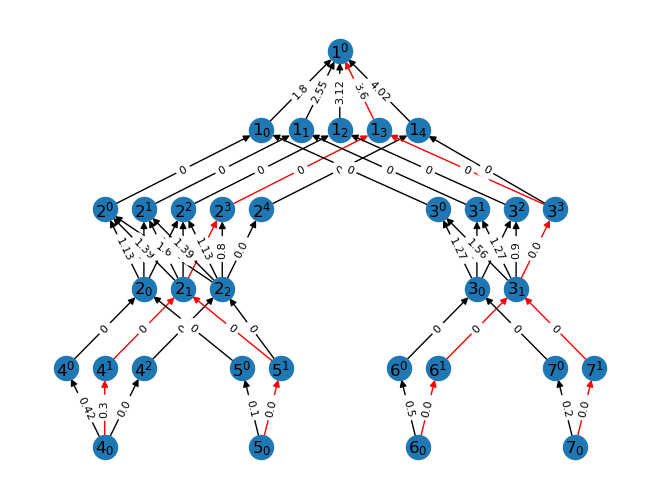

In [802]:
edgesUsedRelaxedMulticommodNoCommod = [(e[0], e[1]) for e in edgesUsedRelaxedMulticommod]
edge_colors = ['red' if edge in edgesUsedRelaxedMulticommodNoCommod else 'black' for edge in extGraph.edges()]
edge_labels = {(u, v): round(data['cost'],2) 
              for u, v, data in extMultiGraph.edges(data=True)}
nx.draw(extGraph, extGraphPos, labels = node_labels, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(extGraph, extGraphPos, edge_labels=edge_labels, font_size=8)
plt.show()

In [803]:
m = getOptimizedShortestPathModelMulticommodity(extGraph, extMultiGraph,log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))

The model is optimal.
Optimal Cost: $ 3.90


## Extended Graph with Options

In [804]:
def createBOM_with_options(bomGraph : nx.DiGraph, bomGraphPos : dict, sameTimes = True, sameCosts = True):
    G = nx.DiGraph()
    G.add_nodes_from(bomGraph.nodes(data=True))
    G.add_edges_from(bomGraph.edges(data=True))
    newPos = bomGraphPos.copy()
    for i in bomGraph.nodes():
        if i in getLeafNodes(bomGraph):
            if sameTimes:
                time = bomGraph.nodes[i]['process_time']
                G.nodes[i]['process_times'] = [time, time]
            else:
                G.nodes[i]['process_times'] = np.random.randint(1, timeUB, numOptions)                                   
            #G.nodes[i]['process_times'] = np.random.randint(1, timeUB, numOptions)
        else:
            time = bomGraph.nodes[i]['process_time']
            G.nodes[i]['process_times'] = [time]
        if sameCosts:
                cost = bomGraph.nodes[i]['stage_cost']
                G.nodes[i]['stage_costs'] = [cost, cost]
        else:
            G.nodes[i]['stage_costs'] = np.random.randint(1, 6, numOptions)
        # cost = bomGraph.nodes[i]['stage_cost']
        # G.nodes[i]['stage_costs'] = [cost, cost]
    return G, newPos

bomOptions, bomOptionsPos = createBOM_with_options(bomGraph, bomGraphPos)

In [805]:
numOptionsForNode = {i : len(bomOptions.nodes[i]['process_times']) for i in bomOptions.nodes()}

def getNumOptionsForNode(G : nx.DiGraph, i : int):
    return len(G.nodes[i]['process_times'])

processTimesDictWithOptions = {(i,j) : bomOptions.nodes[i]['process_times'][j] for i in bomOptions.nodes() for j in range(numOptionsForNode[i])}

In [806]:
def getMaxReplenishmentTimeWithOptions(G : nx.DiGraph, n : int):
    if G.nodes[n]['tier'] == numTiers:
        return max([processTimesDictWithOptions[n, j] for j in range(numOptionsForNode[n])])
    else:
        return processTimesDict[n] + max([getMaxReplenishmentTimeWithOptions(G, i) for i in G.predecessors(n)])
    
maxReplenishmentTimeWithOptions = {n : getMaxReplenishmentTimeWithOptions(bomGraph, n) for n in bomGraph.nodes()}

processTimeOptionsForNode = {i : bomOptions.nodes[i]['process_times'] for i in bomOptions.nodes()}
maxProcessTime = {i : max(bomOptions.nodes[i]['process_times']) for i in bomOptions.nodes()}

df = pd.DataFrame({
    'Node': maxReplenishmentTimeWithOptions.keys(),
    'Process times': processTimeOptionsForNode.values(),
    'Max process time': maxProcessTime.values(),
    'Stage cost': stageCostDict.values(),
    'Cumulative cost': cumCost.values(),
    'Max time': maxServiceTimeOut.values(),
    'maxReplenishmentTime': maxReplenishmentTimeWithOptions.values()
})
df.to_csv('instance.csv')
df

,Node,Process times,Max process time,Stage cost,Cumulative cost,Max time,maxReplenishmentTime
0,1,[1],1,1,18,0,5
1,2,[2],2,4,8,100,4
2,3,[2],2,2,9,100,3
3,4,"[2, 2]",2,3,3,100,2
4,5,"[1, 1]",1,1,1,100,1
5,6,"[1, 1]",1,5,5,100,1
6,7,"[1, 1]",1,2,2,100,1


In [807]:
def get_sOut_range_for_in_and_option(G : nx.DiGraph, node : int, option : int, sIn : int):
    maxVal = sIn + processTimesDictWithOptions[node, option]
    if G.nodes[node]['tier'] < numTiers:
        maxVal = min(maxVal, maxServiceTimeOut[node])
    return range(maxVal+1)

def get_sIn_range_for_option(node : int, option : int):
    return range(1)

def get_sIn_range_with_options(G : nx.DiGraph, node : int):
    tierVal = G.nodes[node]['tier']
    if tierVal == numTiers:
        return range(1)
    if tierVal < numTiers:
        maxVal = maxReplenishmentTimeWithOptions[node] - processTimesDict[node]
        return range(maxVal + 1)

def get_possible_sin_for_sout_at_pred_with_options(G : nx.DiGraph, node : int, sOut_at_pred : int, maxSOut_at_pred : int):
    if sOut_at_pred == maxSOut_at_pred:
        return [sIn for sIn in get_sIn_range_with_options(G, node) if sIn >= sOut_at_pred]
    else:
        return [sOut_at_pred]
    
def get_sOut_range_all_with_options(G : nx.DiGraph,node : int):
    vals = set()
    for sIn in get_sIn_range_with_options(G, node):
        for option in range(numOptionsForNode[node]):
            vals = vals.union(set(get_sOut_range_for_in_and_option(G, node, option, sIn)))
    return vals

In [808]:
def getNodeStringOption(node : int, option : int, s: int, isOut : bool):
    if isOut:
        return "({},{})^{}".format(node, option, s)
    else:
        return "({},{})_{}".format(node, option, s)
    
def getHoldingCostForOption(node : int, option : int, sIn : int, sOut : int):
    return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimeOptionsForNode[node][option] - sOut)

In [809]:
def addInNodes(G : nx.MultiDiGraph, bomOptions : nx.DiGraph, i : int, xOffPerNode, yOffSet, pos : dict, newPos : dict):
    tierVal = bomOptions.nodes[i]['tier']
    if tierVal == numTiers:
        numSIn = len(get_sIn_range_with_options(bomOptions, i))
        xPos = -((numSIn - 1)*xOffPerNode)/2
        for option in range(numOptionsForNode[i]):
            for sIn in get_sIn_range_for_option(i, option):
                inNodeStr = getNodeStringOption(i, option, sIn, False)
                G.add_node(inNodeStr, process_time=0, 
                    max_service_time_out=0,
                    option = option,
                    stage_cost=0, inout = 'in',
                    id = i, 
                    tier = tierVal)
                newPos[inNodeStr] = (pos[i][0] + xPos, pos[i][1] - yOffSet)
                xPos += xOffPerNode
    elif tierVal < numTiers:
        numSIn = len(get_sIn_range_with_options(bomOptions, i))
        xPos = -((numSIn - 1)*xOffPerNode)/2
        for sIn in get_sIn_range_with_options(bomOptions, i):
            inNodeStr = getNodeString(i, sIn, False)
            G.add_node(inNodeStr, process_time=0, 
                max_service_time_out=0,
                stage_cost=0, inout = 'in',
                id = i, 
                tier = tierVal)
            newPos[inNodeStr] = (pos[i][0] + xPos, pos[i][1] - yOffSet)
            xPos += xOffPerNode

def addOutNodes(G : nx.MultiDiGraph, bomOptions : nx.DiGraph, i : int, xOffPerNode, 
                yOffSet, pos : dict, newPos : dict):
    tierVal = bomOptions.nodes[i]['tier']
    if tierVal == numTiers:
        numSOut = len(get_sOut_range_all_with_options(bomOptions, i))
        xPos = -((numSOut - 1)*xOffPerNode)/2
        for sOut in get_sOut_range_all_with_options(bomOptions, i):
            outNodeStr = getNodeString(i, sOut, True)
            G.add_node(outNodeStr, process_time=0, 
                max_service_time_out=0,
                stage_cost=0, inout = 'out',
                id = i,
                tier = bomOptions.nodes[i]['tier'])
            newPos[outNodeStr] = (pos[i][0] + xPos, pos[i][1] + yOffSet)
            xPos += xOffPerNode
    elif tierVal < numTiers:
        numSOut = len(get_sOut_range_all_with_options(bomOptions, i))
        xPos = -((numSOut - 1)*xOffPerNode)/2
        for sOut in get_sOut_range_all_with_options(bomOptions, i):
            outNodeStr = getNodeString(i, sOut, True)
            G.add_node(outNodeStr, process_time=0, 
                max_service_time_out=0,
                stage_cost=0, inout = 'out',
                id = i,
                tier = bomOptions.nodes[i]['tier'])
            newPos[outNodeStr] = (pos[i][0] + xPos, pos[i][1] + yOffSet)
            xPos += xOffPerNode

def addNetTimeEdges(G : nx.MultiDiGraph, bomOptions : nx.DiGraph, i : int):
    tierVal = bomOptions.nodes[i]['tier']
    if tierVal == numTiers:
        for option in range(numOptionsForNode[i]):
            for sIn in get_sIn_range_for_option(i, option): # net time edges
                for sOut in get_sOut_range_for_in_and_option(bomOptions, i, option, sIn):
                    nodeTupleIn = getNodeStringOption(i, option, sIn, False)
                    nodeTupleOut = getNodeString(i, sOut, True)
                    G.add_edge(nodeTupleIn, nodeTupleOut, intime = sIn, outtime = sOut,
                                cost = getHoldingCostForOption(i, option, sIn, sOut), type = 'net-time')
    elif tierVal < numTiers:
        for sIn in get_sIn_range_with_options(bomOptions, i): # net time edges
            for sOut in get_sOut_range_for_g_fn_forIn(bomOptions, i, sIn):
                nodeTupleIn = getNodeString(i, sIn, False)
                nodeTupleOut = getNodeString(i, sOut, True)
                G.add_edge(nodeTupleIn, nodeTupleOut, intime = sIn, outtime = sOut,
                            cost = getHoldingCost(i, sIn, sOut), type = 'net-time')

def addNodeToNodeEdges(G : nx.MultiDiGraph, i : int, j: int):
    tierVal = bomOptions.nodes[i]['tier']
    if tierVal == numTiers:
        maxSOut_at_pred = max(get_sOut_range_all_with_options(bomOptions, i))
        for sOut in get_sOut_range_all_with_options(bomOptions, i):
            for sIn in get_possible_sin_for_sout_at_pred_with_options(bomOptions, j, sOut, maxSOut_at_pred):
                nodeTupleOut = getNodeString(i, sOut, True)
                nodeTupleIn = getNodeString(j, sIn, False)
                G.add_edge(nodeTupleOut, nodeTupleIn, intime = sIn, 
                            outtime = sOut, 
                                cost = 0, type = 'node-to-node')
    elif tierVal < numTiers:
        maxSOut_at_pred = max(get_sOut_range_for_g_fn_all(bomOptions, i))
        for sOut in get_sOut_range_all_with_options(bomOptions, i):
            for sIn in get_possible_sin_for_sout_at_pred(j, sOut, maxSOut_at_pred):
                nodeTupleOut = getNodeString(i, sOut, True)
                nodeTupleIn = getNodeString(j, sIn, False)
                G.add_edge(nodeTupleOut, nodeTupleIn, intime = sIn, 
                            outtime = sOut, 
                                cost = 0, type = 'node-to-node')
    
def createExtendedGraphWithOptions(bomOptions : nx.DiGraph, pos : dict, yOffSet = 0.3):
    G = nx.DiGraph()
    newPos = {}
    xOffPerNode = 0.35
    for i in bomOptions.nodes():
        addInNodes(G, bomOptions, i, xOffPerNode, yOffSet, pos, newPos)
        addOutNodes(G, bomOptions, i, xOffPerNode, yOffSet, pos, newPos)
        addNetTimeEdges(G, bomOptions, i)
    for (i,j) in bomOptions.edges(): # node-to-node edges
        addNodeToNodeEdges(G, i, j)
    return G, newPos

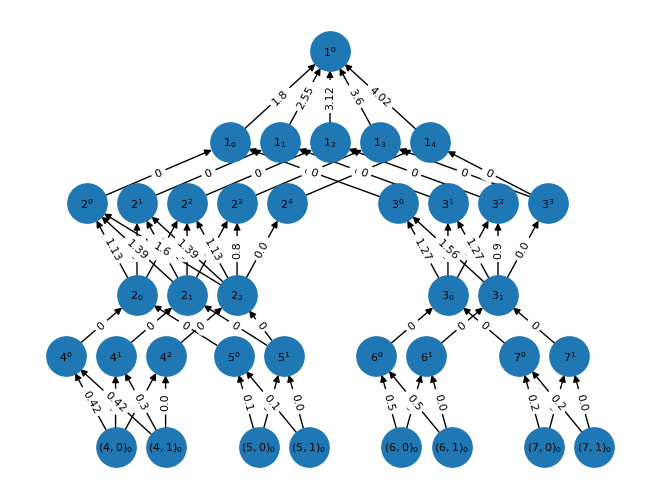

In [810]:
extGraphOptions, newPos = createExtendedGraphWithOptions(bomOptions, bomGraphPos)
node_labels = {node: r'$' +node + '$' for node in extGraphOptions.nodes()}
nx.draw(extGraphOptions, newPos, labels = node_labels, with_labels=True, node_size=800, font_size=8)
edge_labels = {(u, v): round(data['cost'],2) 
              for u, v, data in extGraphOptions.edges(data=True)}
nx.draw_networkx_edge_labels(extGraphOptions, newPos, edge_labels=edge_labels, font_size=8)
plt.show()

## Extended Multicommodity Graph with Options

### Create and Display Graph

In [811]:
def get_descendent_part_options(G: nx.DiGraph, node):
    myList = [(i,j) for i in nx.ancestors(G, node) if G.nodes[i]['tier'] == numTiers 
              for j in range(getNumOptionsForNode(G, i))]
    if G.nodes[node]['tier'] == numTiers:
        myList.extend([(node,j) for j in range(numOptionsForNode[node])])
    return myList

# def getHoldingCostAtNodeFoPartOption(node : int, option : int, sIn : int, sOut : int):
#     return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimeOptionsForNode[node][option] - sOut)

# def getLocalHoldingCostForOption(node : int, option : int, sIn : int, sOut : int):
#     return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimeOptionsForNode[node][option] - sOut)

# def getCostOfMulticommodityEdgeWithOption(extGraphOptions : nx.DiGraph, e, part : int, option: int):
#     if e[2]['type'] == 'net-time':
#         id = extGraphOptions.nodes[e[0]]['id']
#         #print(e[0], e[1], e[2]['intime'], e[2]['outtime'])
#         return getHoldingCost(id, e[2]['intime'], e[2]['outtime'])
#         #getHoldingCostForOption(id, option, e[2]['intime'], e[2]['outtime'])
#         #return getHoldingCost(id, e[2]['intime'], e[2]['outtime'])
#         #return getHoldingCostForOption(e[0], e[2]['option'], e[2]['intime'], e[2]['outtime'])
#     elif e[2]['type'] == 'node-to-node':
#         return 0

In [812]:
def createExtendedMultiGraphWithOptions(bomGraphOptions : nx.DiGraph, 
                                        extGraphOptions : nx.DiGraph, 
                                        pos : dict, yOffSet = 0.85):
    G = nx.MultiDiGraph()
    G.add_nodes_from(extGraphOptions.nodes(data=True))
    for i in G.nodes():
        if G.nodes[i]['tier'] == 0 and G.nodes[i]['inout'] == 'out':
            G.nodes[i]['netflow'] = -1
        else:
            G.nodes[i]['netflow'] = 0
    newPos = pos.copy()
    for i in getLeafNodes(bomGraphOptions):
        G.add_node(i, tier = numTiers, id = i, netflow = 1)
        bomPos = bomGraphOptions.nodes[i]['pos']
        newPos[i] = (bomPos[0], bomPos[1] - yOffSet)
        for j in extGraphOptions.nodes():
            if extGraphOptions.nodes[j]['id'] == i and extGraphOptions.nodes[j]['inout'] == 'in':
                G.add_edge(i,j, cost = 0, partOption = (i, extGraphOptions.nodes[j]['option']), 
                           type = 'option')
    for e in extGraphOptions.edges(data = True):
        id = extGraphOptions.nodes[e[0]]['id']
        for (p,j) in get_descendent_part_options(bomGraphOptions, id):
            attrDict = e[2]
            #attrDict['cost'] = getCostOfMulticommodityEdgeWithOption(extGraphOptions, e, p, j)
            attrDict['partOption'] = (p,j)
            G.add_edge(e[0], e[1], **attrDict)
    return G, newPos

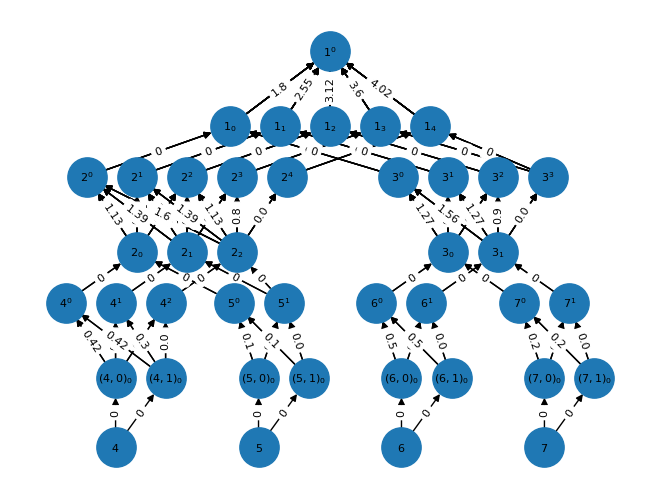

In [813]:
extMultiGraphOptions, extMultiGraphPos = createExtendedMultiGraphWithOptions(bomOptions, 
                                                           extGraphOptions, newPos)

node_labels = {node: r'$' +str(node) + '$' for node in extMultiGraphOptions.nodes()}
nx.draw(extMultiGraphOptions, extMultiGraphPos, labels = node_labels, with_labels=True, 
        node_size=800, font_size=8)
edge_labels = {(u, v): round(data['cost'],2)
              for u, v, data in extMultiGraphOptions.edges(data=True)}
nx.draw_networkx_edge_labels(extMultiGraphOptions, extMultiGraphPos, edge_labels=edge_labels, 
                             font_size=8)
plt.show()

### Show Shortest Paths

4 cost:  3.355634918610405
5 cost:  3.0313708498984764
6 cost:  3.35884572681199
7 cost:  3.2727922061357857
total cost:  13.018643701456657


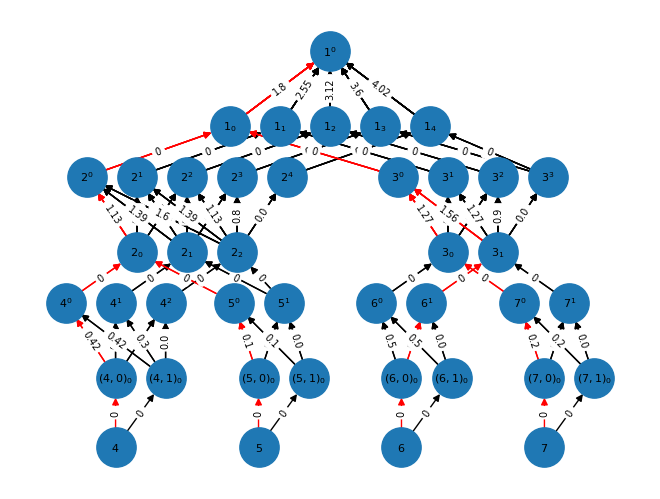

In [814]:
edgesUsed = []
totalCost = 0
for n in range(4,8):
    shortest_path = nx.shortest_path(extMultiGraphOptions, n, '1^0', weight='cost')
    shortest_path_length = nx.shortest_path_length(extMultiGraphOptions, n, '1^0', weight='cost')
    totalCost += shortest_path_length
    edges_in_path = list(zip(shortest_path[:-1], shortest_path[1:]))
    edgesUsed.extend(edges_in_path)
    print(n, "cost: ", shortest_path_length)
edgesUsedSet = set(edgesUsed)
print("total cost: ", totalCost)

edge_colors = ['red' if edge in edgesUsedSet else 'black' 
               for edge in extMultiGraphOptions.edges()]

nx.draw(extMultiGraphOptions, extMultiGraphPos, labels = node_labels, edge_color=edge_colors, 
        with_labels=True, node_size=800, font_size=8)
nx.draw_networkx_edge_labels(extMultiGraphOptions, extMultiGraphPos, edge_labels=edge_labels, font_size=7)
plt.savefig("optionsMulticommod.jpg")
plt.show()

### Solve LP

In [815]:
def getCommodityEdgesWithOptions(extMultiGraphOptions : nx.MultiDiGraph):
    return [(e[0], e[1], e[2]['partOption'][0], e[2]['partOption'][1]) 
            for e in extMultiGraphOptions.edges(data = True)]

def getAllNodeToNodeEdgeCommoditiesWithOptions(G : nx.MultiDiGraph):
    for e in G.edges(data = True):
        if e[2]['type'] == 'node-to-node':
            yield (e[0], e[1], e[2]['partOption'][0], 
                   e[2]['partOption'][1])

def getAllNetTimeEdgeCommoditiesWithOptions(G : nx.MultiDiGraph):
    for e in G.edges(data = True):
        if e[2]['type'] == 'net-time':
            yield (e[0], e[1], e[2]['partOption'][0], 
                   e[2]['partOption'][1])

# def getNetFlowExprWithPartOption(G, x, node, partOption):
#     in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNode(G, node) 
#                         if (e[2]['partOption'][0],e[2]['partOption'][1]) == partOption)
#     out_edges_sum = qsum(x[e] for e in getCommodityOutEdges(G, node) 
#                          if (e[2]['partOption'][0],e[2]['partOption'][1]) == partOption)
#     return out_edges_sum - in_edges_sum

def getCommodityInEdgesForNodeWithOptions(G, node):
    return [(e[0], e[1], e[2]['partOption'][0], 
                   e[2]['partOption'][1]) 
                   for e in G.in_edges(node, data = True)]

def getCommodityOutEdgesForNodeWithOptions(G, node):
    return [(e[0], e[1], e[2]['partOption'][0], 
                   e[2]['partOption'][1]) 
                   for e in G.out_edges(node, data = True)]

def getNetFlowExprWithOptionsForLeafAndEndNodes(G, x, node):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNodeWithOptions(G, node))
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdgesForNodeWithOptions(G, node))
    return out_edges_sum - in_edges_sum

def getOutFlowExprForPartOption(G, x, n, partOption):
    return qsum(x[e] for e in getCommodityOutEdgesForNodeWithOptions(G, n) if (e[2], e[3]) == partOption)

def getNetFlowExprForPartOption(G, x, n, partOption):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNodeWithOptions(G, n) if (e[2], e[3]) == partOption)
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdgesForNodeWithOptions(G, n) if (e[2], e[3]) == partOption)
    return out_edges_sum - in_edges_sum

edgeCostCommodityWithOptions = {(e[0], e[1], e[2]['partOption'][0], e[2]['partOption'][1]) : e[2]['cost'] 
                for e in extMultiGraphOptions.edges(data = True)}

edgeCostZWithOptions = {(e[0], e[1]) : e[2]['cost']
            for e in getAllNetTimeEdgeWithData(extGraphOptions)}

def getNumOptionsForNodeMultiGraph(extMultiGraphOptions: nx.MultiDiGraph, bomGraphOptions : nx.DiGraph, i : int):
    id = extMultiGraphOptions.nodes[i]['id']
    return len(bomGraphOptions.nodes[id]['process_times'])

def get_descendent_part_options_multiGraph(extMultiGraphOptions: nx.MultiDiGraph, bomGraphOptions : nx.DiGraph, node):
    id = extMultiGraphOptions.nodes[node]['id']
    return get_descendent_part_options(bomGraphOptions, id)

In [816]:
getCommodityOutEdgesForNodeWithOptions(extMultiGraphOptions, 4)

[(4, '(4,0)_0', 4, 0), (4, '(4,1)_0', 4, 1)]

In [817]:
def getOptimizedShortestPathModelMulticommodityWithOptions(bomOptions : nx.DiGraph,
                                                           extGraphOptions : nx.DiGraph,
                                                extMultiGraphOptions : nx.MultiDiGraph,
                                                componentOptionStatus = dict, 
                                                vtypeZ = GRB.BINARY, 
                                                log = False):
    m = gp.Model("shortest_paths - MC - options")
    m.Params.LogToConsole = log
    x = m.addVars(getCommodityEdgesWithOptions(extMultiGraphOptions), name="x")
    z = m.addVars(getAllNetTimeEdges(extGraphOptions), name="z", vtype=vtypeZ)
    m._x = x
    m._z = z

    m.setObjective(qsum(edgeCostCommodityWithOptions[e]*x[e] for e in getAllNodeToNodeEdgeCommoditiesWithOptions(extMultiGraphOptions)) + 
                qsum(z[e]*edgeCostZWithOptions[e] for e in z), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= z[e[0],e[1]] 
                  for e in getAllNetTimeEdgeCommoditiesWithOptions(extMultiGraphOptions)), 
                 "UB-z")
    m.addConstrs((getNetFlowExprWithOptionsForLeafAndEndNodes(extMultiGraphOptions, x, n) == 1
                for n in getLeafNodes(bomOptions)), 
                "flow-conserv-leaf")
    m.addConstr(getNetFlowExprWithOptionsForLeafAndEndNodes(extMultiGraphOptions, x, '1^0') == -4, 
                "flow-conserv-terminal")
    nonLeafAndTerminalNodes = extMultiGraphOptions.nodes() - getLeafNodes(bomOptions) - {'1^0'}
    m.addConstrs((getNetFlowExprForPartOption(extMultiGraphOptions, x, n, (p,o)) == extMultiGraphOptions.nodes[n]['netflow']
                for n in nonLeafAndTerminalNodes for (p,o) in get_descendent_part_options_multiGraph(extMultiGraphOptions, bomOptions, n)), 
                "flow-conserv-others")
    m.addConstrs((getOutFlowExprForPartOption(extMultiGraphOptions, x, n, (n, o)) <= componentOptionStatus[n, o]
                  for n in getLeafNodes(bomOptions) for o in range(getNumOptionsForNode(bomOptions, n))), "part-status")
    m.optimize()
    m.write("multicommodity.lp")
    handleGurobiStatus(m)
    return m

In [818]:
componentOptionStatus = {(n,j) : 1 for n in getLeafNodes(bomOptions) for j in range(getNumOptionsForNode(bomOptions, n))}
componentOptionStatus[4,1] = 0
componentOptionStatus[5,1] = 0
componentOptionStatus[6,1] = 0
componentOptionStatus[7,1] = 0
m = getOptimizedShortestPathModelMulticommodityWithOptions(bomOptions, extGraphOptions, 
                                                           extMultiGraphOptions, componentOptionStatus, 
                                                vtypeZ = GRB.CONTINUOUS, log = False)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))

edgesUsedRelaxedMulticommod = [e for e in m._x if m._x[e].x > 0.0]
varValues = [m._x[e].X for e in m._x if m._x[e].x > 0.0]
costs = [edgeCostCommodityWithOptions[e] for e in edgesUsedRelaxedMulticommod]

df = pd.DataFrame({
    'Edge used': edgesUsedRelaxedMulticommod,
    'Value': varValues,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
print(df)

The model is optimal.
Relaxed Cost: $ 3.90
               Edge used  Value Holding cost
0       (1_3, 1^0, 4, 0)    1.0        $3.60
1       (1_3, 1^0, 5, 0)    1.0        $3.60
2       (1_3, 1^0, 6, 0)    1.0        $3.60
3       (1_3, 1^0, 7, 0)    1.0        $3.60
4       (2_1, 2^3, 4, 0)    1.0        $0.00
5       (2_1, 2^3, 5, 0)    1.0        $0.00
6       (2^3, 1_3, 4, 0)    1.0        $0.00
7       (2^3, 1_3, 5, 0)    1.0        $0.00
8       (3_1, 3^3, 6, 0)    1.0        $0.00
9       (3_1, 3^3, 7, 0)    1.0        $0.00
10      (3^3, 1_3, 6, 0)    1.0        $0.00
11      (3^3, 1_3, 7, 0)    1.0        $0.00
12  ((4,0)_0, 4^1, 4, 0)    1.0        $0.30
13      (4^1, 2_1, 4, 0)    1.0        $0.00
14  ((5,0)_0, 5^1, 5, 0)    1.0        $0.00
15      (5^1, 2_1, 5, 0)    1.0        $0.00
16  ((6,0)_0, 6^1, 6, 0)    1.0        $0.00
17      (6^1, 3_1, 6, 0)    1.0        $0.00
18  ((7,0)_0, 7^1, 7, 0)    1.0        $0.00
19      (7^1, 3_1, 7, 0)    1.0        $0.00
20    (4, (4

In [819]:
edgesUsedZ = list({e for e in m._z if m._z[e].x > 0.0})
zVals = [m._z[e].X for e in m._z if m._z[e].x > 0.0]
costsZ = [edgeCostZWithOptions[e] for e in edgesUsedZ]
df = pd.DataFrame({
    'Edge used': edgesUsedZ,
    'Value': zVals,
    'Holding cost': costsZ
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)

print(df)

        Edge used  Value Holding cost
0  ((6,0)_0, 6^1)    1.0        $0.00
1  ((4,0)_0, 4^1)    1.0        $0.30
2      (3_1, 3^3)    1.0        $0.00
3      (2_1, 2^3)    1.0        $0.00
4  ((5,0)_0, 5^1)    1.0        $0.00
5  ((7,0)_0, 7^1)    1.0        $0.00
6      (1_3, 1^0)    1.0        $3.60


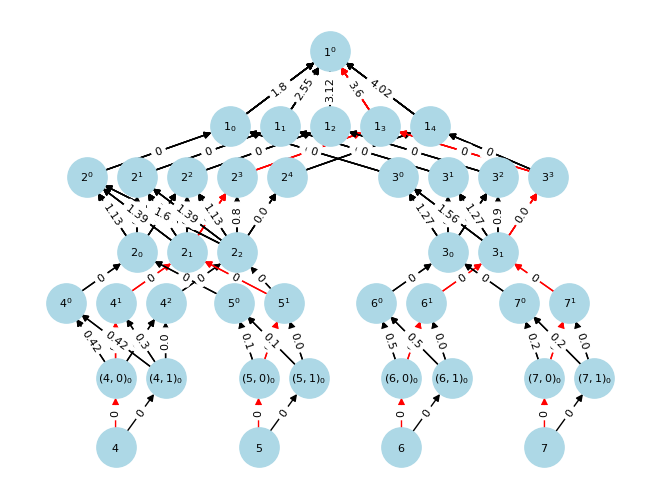

In [820]:
edgesUsedRelaxedMulticommodNoCommod = [(e[0], e[1]) for e in edgesUsedRelaxedMulticommod]

edge_colors = ['red' if edge in edgesUsedRelaxedMulticommodNoCommod else 'black' 
               for edge in extMultiGraphOptions.edges()]

nx.draw(extMultiGraphOptions, extMultiGraphPos, labels = node_labels, edge_color=edge_colors, 
        with_labels=True, node_size=800, font_size=8, node_color='lightblue')
nx.draw_networkx_edge_labels(extMultiGraphOptions, extMultiGraphPos, edge_labels=edge_labels, font_size=8)
plt.savefig("optionsMulticommod-LP-relaxed.jpg")
plt.show()

### Get Dual Multipliers

In [821]:
if m.status == GRB.OPTIMAL:
    for c in m.getConstrs():
        print(f'Constraint: {c.ConstrName}, Dual Value: {c.Pi}')

Constraint: UB-z[1_0,1^0,4,0], Dual Value: -1.8
Constraint: UB-z[1_0,1^0,4,1], Dual Value: 0.0
Constraint: UB-z[1_0,1^0,5,0], Dual Value: 0.0
Constraint: UB-z[1_0,1^0,5,1], Dual Value: 0.0
Constraint: UB-z[1_0,1^0,6,0], Dual Value: 0.0
Constraint: UB-z[1_0,1^0,6,1], Dual Value: 0.0
Constraint: UB-z[1_0,1^0,7,0], Dual Value: 0.0
Constraint: UB-z[1_0,1^0,7,1], Dual Value: 0.0
Constraint: UB-z[1_1,1^0,4,0], Dual Value: -2.2242640687119284
Constraint: UB-z[1_1,1^0,4,1], Dual Value: 0.0
Constraint: UB-z[1_1,1^0,5,0], Dual Value: -0.035266822883439186
Constraint: UB-z[1_1,1^0,5,1], Dual Value: 0.0
Constraint: UB-z[1_1,1^0,6,0], Dual Value: -0.08605352067620387
Constraint: UB-z[1_1,1^0,6,1], Dual Value: 0.0
Constraint: UB-z[1_1,1^0,7,0], Dual Value: -0.19999999999999996
Constraint: UB-z[1_1,1^0,7,1], Dual Value: 0.0
Constraint: UB-z[1_2,1^0,4,0], Dual Value: -2.2242640687119284
Constraint: UB-z[1_2,1^0,4,1], Dual Value: 0.0
Constraint: UB-z[1_2,1^0,5,0], Dual Value: -0.034581658100061086
Cons

### Binary Variable Version of Model

In [822]:
m = getOptimizedShortestPathModelMulticommodityWithOptions(bomOptions, extGraphOptions, 
                                                           extMultiGraphOptions,
                                                           componentOptionStatus, 
                                                vtypeZ = GRB.BINARY, log = False)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))

edgesUsedOptimalMulticommod = [e for e in m._x if m._x[e].x > 0.0]
varValues = [m._x[e].X for e in m._x if m._x[e].x > 0.0]
costs = [edgeCostCommodityWithOptions[e] for e in edgesUsedOptimalMulticommod]

df = pd.DataFrame({
    'Edge used': edgesUsedOptimalMulticommod,
    'Value': varValues,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
print(df)

The model is optimal.
Relaxed Cost: $ 3.90
               Edge used  Value Holding cost
0       (1_3, 1^0, 4, 0)    1.0        $3.60
1       (1_3, 1^0, 5, 0)    1.0        $3.60
2       (1_3, 1^0, 6, 0)    1.0        $3.60
3       (1_3, 1^0, 7, 0)    1.0        $3.60
4       (2_1, 2^3, 4, 0)    1.0        $0.00
5       (2_1, 2^3, 5, 0)    1.0        $0.00
6       (2^3, 1_3, 4, 0)    1.0        $0.00
7       (2^3, 1_3, 5, 0)    1.0        $0.00
8       (3_1, 3^3, 6, 0)    1.0        $0.00
9       (3_1, 3^3, 7, 0)    1.0        $0.00
10      (3^3, 1_3, 6, 0)    1.0        $0.00
11      (3^3, 1_3, 7, 0)    1.0        $0.00
12  ((4,0)_0, 4^1, 4, 0)    1.0        $0.30
13      (4^1, 2_1, 4, 0)    1.0        $0.00
14  ((5,0)_0, 5^1, 5, 0)    1.0        $0.00
15      (5^1, 2_1, 5, 0)    1.0        $0.00
16  ((6,0)_0, 6^1, 6, 0)    1.0        $0.00
17      (6^1, 3_1, 6, 0)    1.0        $0.00
18  ((7,0)_0, 7^1, 7, 0)    1.0        $0.00
19      (7^1, 3_1, 7, 0)    1.0        $0.00
20    (4, (4

In [823]:
edgesUsedZ = list({e for e in m._z if m._z[e].x > 0.0})
zVals = [m._z[e].X for e in m._z if m._z[e].x > 0.0]
costsZ = [edgeCostZWithOptions[e] for e in edgesUsedZ]
df = pd.DataFrame({
    'Edge used': edgesUsedZ,
    'Value': zVals,
    'Holding cost': costsZ
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)

print(df)

         Edge used  Value Holding cost
0       (2_0, 2^2)    1.0        $0.00
1   ((7,1)_0, 7^1)    1.0        $0.00
2   ((5,1)_0, 5^1)    1.0        $0.00
3   ((4,0)_0, 4^1)    1.0        $0.30
4       (3_1, 3^3)    1.0        $0.00
5   ((6,0)_0, 6^1)    1.0        $0.00
6       (2_1, 2^3)    1.0        $0.00
7   ((4,0)_0, 4^2)    1.0        $0.00
8   ((6,1)_0, 6^1)    1.0        $0.00
9       (3_0, 3^2)    1.0        $0.00
10  ((4,1)_0, 4^2)    1.0        $0.00
11      (2_2, 2^4)    1.0        $0.00
12  ((5,0)_0, 5^1)    1.0        $0.00
13  ((7,0)_0, 7^1)    1.0        $0.00
14      (1_3, 1^0)    1.0        $3.60


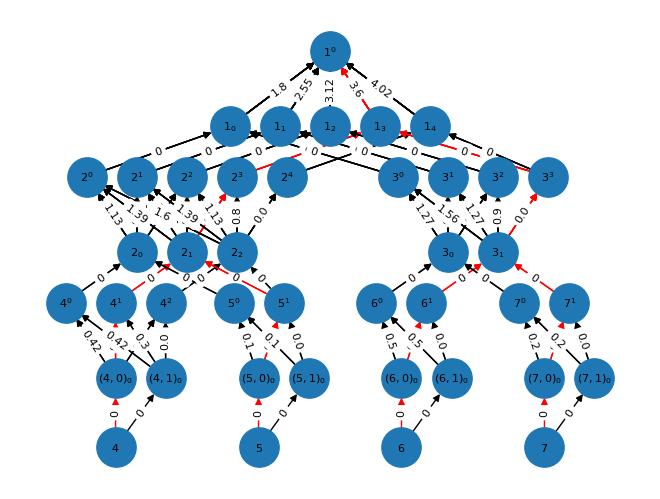

In [824]:
edgesUsedRelaxedMulticommodNoCommod = [(e[0], e[1]) for e in edgesUsedOptimalMulticommod]

edge_colors = ['red' if edge in edgesUsedRelaxedMulticommodNoCommod else 'black' 
               for edge in extMultiGraphOptions.edges()]

nx.draw(extMultiGraphOptions, extMultiGraphPos, labels = node_labels, edge_color=edge_colors, 
        with_labels=True, node_size=800, font_size=8)
nx.draw_networkx_edge_labels(extMultiGraphOptions, extMultiGraphPos, edge_labels=edge_labels, font_size=8)
plt.savefig("optionsMulticommod-LP-binary.jpg")
plt.show()